In [1]:
import re
import os
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
class opt:
    niter = 300
    lr = 0.0002
    drop_lr = 5
    beta1 = 0.5
    niter_decay = 100
    dataset = 'cityscapesAB'
    which_direction = 'AtoB'
    resize_or_crop = 'crop'
    no_flip = False
    ignore_index = 0
    unsup_portion = 89
    portion_total = 90
    unsup_sampler = 'sep'
    name = 'xyx'
    checkpoints_dir = 'checkpoints'
    save_every = 2
    manual_seed = 123
    start_epoch = 0
    nThreads = 4
    gpu_ids = ''
    stage = 'F'
    lambda_x = 1.0
    lambda_y = 1.0
    lrFGD = '1e-4'
    batchSize = 4
    widthSize = 32
    heightSize = 32
    input_nc = 3
    output_nc = 2
    nz = 100
    use_dropout = True
    ngf = 64
    ndf = 64
    noise = 'sphere'
    n_layers_D = 3
    display_winsize = 256
    display_id = 1
    port = 8097
    no_html = False

In [4]:
re_eval_miou = re.compile("\'Mean IoU\': \d+\.\d+")
re_eval_CE   = re.compile("average CE = \d+\.\d+")
re_DG   = re.compile("D/G: \d+\.\d+/\d+\.\d+")
re_CE   = re.compile("P_CE/A_CE: \d+\.\d+/\d+\.\d+")
re_L1   = re.compile("P_L1/A_L1: \d+\.\d+/\d+\.\d+")

In [5]:
valid_experiments = range(10,15)
#invalid_experiments = [10, 14, 18, 22]
invalid_experiments = []
valid_experiments = [x for x in valid_experiments if x not in invalid_experiments]
print(valid_experiments)

[10, 11, 12, 13, 14]


In [13]:
def load_log(name, stage_str, lrFGD, lb):
    outfile = "../logs/%s_%s_b%d/stage%s_lrFGD%s_lb%.3f.log" \
              % (name, opt.dataset, opt.batchSize, stage_str, lrFGD, lb)
    print(outfile)
    #assert( os.path.exists(outfile) )
    if not os.path.exists(outfile):
        return [-9999]
    with open(outfile, 'r') as log_f:
        ious = re.findall(re_eval_miou, log_f.read())
        ious = [float(iou.split(': ')[1]) for iou in ious]
        return ious


def load_max_over_lb(name, lrFGD, lambda_xs, stage_str):
    all_ious = []
    amax = -1
    max_iou = -1

    for j,lb in enumerate(lambda_xs):
        ious = load_log(name, stage_str, lrFGD, lb)
        all_ious.append(ious)
        if max(ious) > max_iou:
            max_iou = max(ious)
            amax = j
    #print('%s: max_iou = %f, amax = %d' % (name, max_iou, amax))
    return all_ious[amax], amax


def load_max_over_lr(name, lst_lrFGD, lb, stage_str):
    all_ious = []
    amax = -1
    max_iou = -1

    for j,lrFGD in enumerate(lst_lrFGD):
        ious = load_log(name, stage_str, lrFGD, lb)
        all_ious.append(ious)
        if max(ious) > max_iou:
            max_iou = max(ious)
            amax = j
    #print('%s: max_iou = %f, amax = %d' % (name, max_iou, amax))
    return all_ious[amax], amax

In [16]:
# stage F
stage_str = 'F:2,G:0,D:0'
lrs = [1e-2, 1e-3, 1e-4]
lb = 1.0

all_ious = []
all_lr_F = [] # 

for j,i in enumerate(valid_experiments):
    name = '%s_%d' % (opt.name, i)
    lst_lrFGD = ['%.1e,%.1e,%.1e' % (lr,lr,lr) for lr in lrs]
    ious,amax = load_max_over_lr(name, lst_lrFGD, lb, stage_str)
    all_ious.append(ious)
    all_lr_F.append(lrs[amax])

F_ious = np.stack(all_ious, axis=0)
print(F_ious)

../logs/xyx_10_cityscapesAB_b4/stageF:2,G:0,D:0_lrFGD1.0e-02,1.0e-02,1.0e-02_lb1.000.log
../logs/xyx_10_cityscapesAB_b4/stageF:2,G:0,D:0_lrFGD1.0e-03,1.0e-03,1.0e-03_lb1.000.log
../logs/xyx_10_cityscapesAB_b4/stageF:2,G:0,D:0_lrFGD1.0e-04,1.0e-04,1.0e-04_lb1.000.log
../logs/xyx_11_cityscapesAB_b4/stageF:2,G:0,D:0_lrFGD1.0e-02,1.0e-02,1.0e-02_lb1.000.log
../logs/xyx_11_cityscapesAB_b4/stageF:2,G:0,D:0_lrFGD1.0e-03,1.0e-03,1.0e-03_lb1.000.log
../logs/xyx_11_cityscapesAB_b4/stageF:2,G:0,D:0_lrFGD1.0e-04,1.0e-04,1.0e-04_lb1.000.log
../logs/xyx_12_cityscapesAB_b4/stageF:2,G:0,D:0_lrFGD1.0e-02,1.0e-02,1.0e-02_lb1.000.log
../logs/xyx_12_cityscapesAB_b4/stageF:2,G:0,D:0_lrFGD1.0e-03,1.0e-03,1.0e-03_lb1.000.log
../logs/xyx_12_cityscapesAB_b4/stageF:2,G:0,D:0_lrFGD1.0e-04,1.0e-04,1.0e-04_lb1.000.log
../logs/xyx_13_cityscapesAB_b4/stageF:2,G:0,D:0_lrFGD1.0e-02,1.0e-02,1.0e-02_lb1.000.log
../logs/xyx_13_cityscapesAB_b4/stageF:2,G:0,D:0_lrFGD1.0e-03,1.0e-03,1.0e-03_lb1.000.log
../logs/xyx_13_citysc

In [17]:
# stage GD
stage_str = 'F:1,G:2,D:2'
lr_GD = 1e-4
all_lr_GD = [lr_GD] * len(valid_experiments) #

In [50]:
# stage F2
#stage_str = 'F:2,G:1,D:1'
#lambda_xs = [100, 10, 1, 1e-1, 1e-2]

#all_ious = []
#all_lb = [] #

#for j,i in enumerate(valid_experiments):
#    name = '%s_%d' % (opt.name, i)
#    lrFGD = '%.1e,%.1e,%.1e' % (all_lr_F[j],all_lr_GD[j],all_lr_GD[j])
#    ious,amax = load_max_over_lb(name, lrFGD, lambda_xs, stage_str)
#    all_ious.append(ious)
#    all_lb.append(lambda_xs[amax])

#F2_ious = np.stack(all_ious, axis=0)

In [39]:
# stage FGD
stage_str = 'F:2,G:2,D:2'
all_ious = []
max_len = 1000
for j,i in enumerate(valid_experiments):
    name = '%s_%d' % (opt.name, i)
    #lb = all_lb[j]
    lb = 1e-2
    lr_F = all_lr_F[j]
    lr_GD = all_lr_GD[j]
    lrFGD = '%.1e,%.1e,%.1e' % (lr_F, lr_GD / lb, lr_GD / lb)
    
    ious = load_log(name, stage_str, lrFGD, lb)
    all_ious.append(ious)
    
    if len(ious) <= max_len:
        max_len = len(ious)

#FGD_ious = np.stack(all_ious, axis=0)
FGD_ious = [ii[:max_len] for ii in all_ious]

../logs/xyx_10_cityscapesAB_b4/stageF:2,G:2,D:2_lrFGD1.0e-04,1.0e-02,1.0e-02_lb0.010.log
../logs/xyx_11_cityscapesAB_b4/stageF:2,G:2,D:2_lrFGD1.0e-04,1.0e-02,1.0e-02_lb0.010.log
../logs/xyx_12_cityscapesAB_b4/stageF:2,G:2,D:2_lrFGD1.0e-04,1.0e-02,1.0e-02_lb0.010.log
../logs/xyx_13_cityscapesAB_b4/stageF:2,G:2,D:2_lrFGD1.0e-04,1.0e-02,1.0e-02_lb0.010.log
../logs/xyx_14_cityscapesAB_b4/stageF:2,G:2,D:2_lrFGD1.0e-04,1.0e-02,1.0e-02_lb0.010.log


In [25]:
color_map = dict(F=sns.xkcd_rgb["denim blue"], F2=sns.xkcd_rgb["medium green"], FGD=sns.xkcd_rgb["orange"])

/home/hushell/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


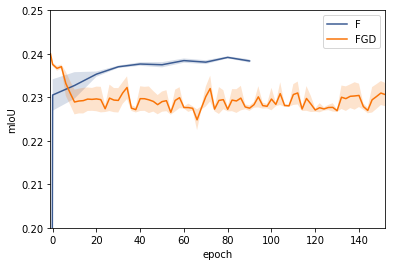

In [53]:
# Comparison between stage F and stage FGD
def plotter():
    epochs1 = pd.Series([-1] + list(range(0, (max_len-1)*2, 2)), name="epoch")
    epochs2 = pd.Series([-1] + list(range(0, 100, 10)), name="epoch")
    sns.tsplot(data=F_ious, time=epochs2, condition=['F'], value='mIoU', color=color_map)
    sns.tsplot(data=FGD_ious, time=epochs1, condition=['FGD'], value='mIoU', color=color_map)
    plt.ylim(0.2, 0.25)
    plt.xlim(-1, None)
    plt.show()
    
plotter()